In [16]:
import keras
from keras.layers import Conv2D
from keras.layers import ConvLSTM2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Softmax
from keras.layers import MaxPooling2D
from keras.models import Sequential
import numpy as np
import pickle
import matplotlib.pyplot as plt
#from DataFactory import generate

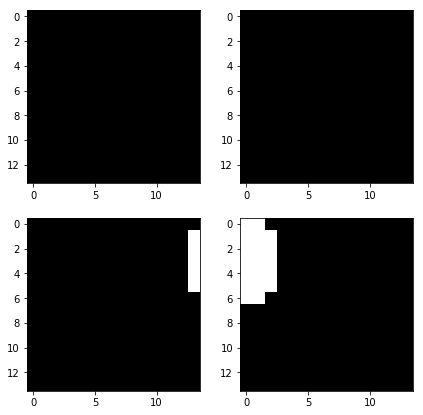

In [17]:
with open("images_simple", "rb") as f:
    images = np.asarray(pickle.load(f))
with open("vectors_simple", "rb") as f:
    vectors = np.asarray(pickle.load(f))
#sort of normalizes (?) target vector?
for v in range(vectors.shape[0]):
    vectors[v][2] *= 10
    vectors[v][3] *= 10
vectors = vectors.reshape(vectors.shape[0], 4)
images = images.reshape(images.shape[0], 28, 28, 1)

train_seq = np.zeros((len(images), 4, 14, 14))
for i in range(len(images)):
    train_seq[i][0] = images[i][0:14, 0:14].reshape(14, 14)
    train_seq[i][1] = images[i][0:14, 14:28].reshape(14, 14)
    train_seq[i][2] = images[i][14:28, 0:14].reshape(14, 14)
    train_seq[i][3] = images[i][14:28, 14:28].reshape(14, 14)
train_seq = train_seq.reshape(-1, 4, 14, 14, 1)
images = train_seq

fig = plt.figure(figsize=(7, 7))
sample = np.random.randint(len(images))
fig.add_subplot(2,2, 1)
plt.imshow(images[sample, 0].reshape(14,14) , cmap='gray')
fig.add_subplot(2,2, 2)
plt.imshow(images[sample, 1].reshape(14,14) , cmap='gray')
fig.add_subplot(2,2, 3)
plt.imshow(images[sample, 2].reshape(14,14) , cmap='gray')
fig.add_subplot(2,2, 4)
plt.imshow(images[sample, 3].reshape(14,14) , cmap='gray')
plt.show()

In [21]:
'''
Equivalent non-reccurent model would have 78,560 parameters to learn.
40 2x2 convolutions plus a 1960x10 dense layer yields 78,560 parameters.

This LSTM learns only 46,170 parameters
'''
model = Sequential()

model.add(ConvLSTM2D(40, kernel_size=(2,2), padding="same", input_shape=(4,14,14,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(rate=.5))

model.add(Reshape((1960,)))
model.add(Dense(4))
#model.add(Activation("softmax"))

In [22]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [23]:
model.fit(images, vectors, validation_split=.2, epochs=8, shuffle=True, batch_size=32)

Train on 8000 samples, validate on 2000 samples
Epoch 1/8
8000/8000 [==============================] - 57s 7ms/step - loss: 3.3734 - acc: 0.6326 - val_loss: 1.0471 - val_acc: 0.8335
Epoch 2/8
8000/8000 [==============================] - 54s 7ms/step - loss: 1.2887 - acc: 0.8170 - val_loss: 0.9316 - val_acc: 0.8810
Epoch 3/8
8000/8000 [==============================] - 48s 6ms/step - loss: 0.8754 - acc: 0.8645 - val_loss: 0.4523 - val_acc: 0.9060
Epoch 4/8
8000/8000 [==============================] - 47s 6ms/step - loss: 0.7247 - acc: 0.8845 - val_loss: 0.4662 - val_acc: 0.9290
Epoch 5/8
8000/8000 [==============================] - 46s 6ms/step - loss: 0.6351 - acc: 0.8970 - val_loss: 0.3181 - val_acc: 0.9375
Epoch 6/8
8000/8000 [==============================] - 49s 6ms/step - loss: 0.5838 - acc: 0.9011 - val_loss: 0.4302 - val_acc: 0.9185
Epoch 7/8
8000/8000 [==============================] - 49s 6ms/step - loss: 0.5574 - acc: 0.9004 - val_loss: 0.3733 - val_acc: 0.9355
Epoch 8/8
8000

[2.0255382 2.9358299 4.4981375 5.682574 ]
[2.  3.  5.2 6.2]


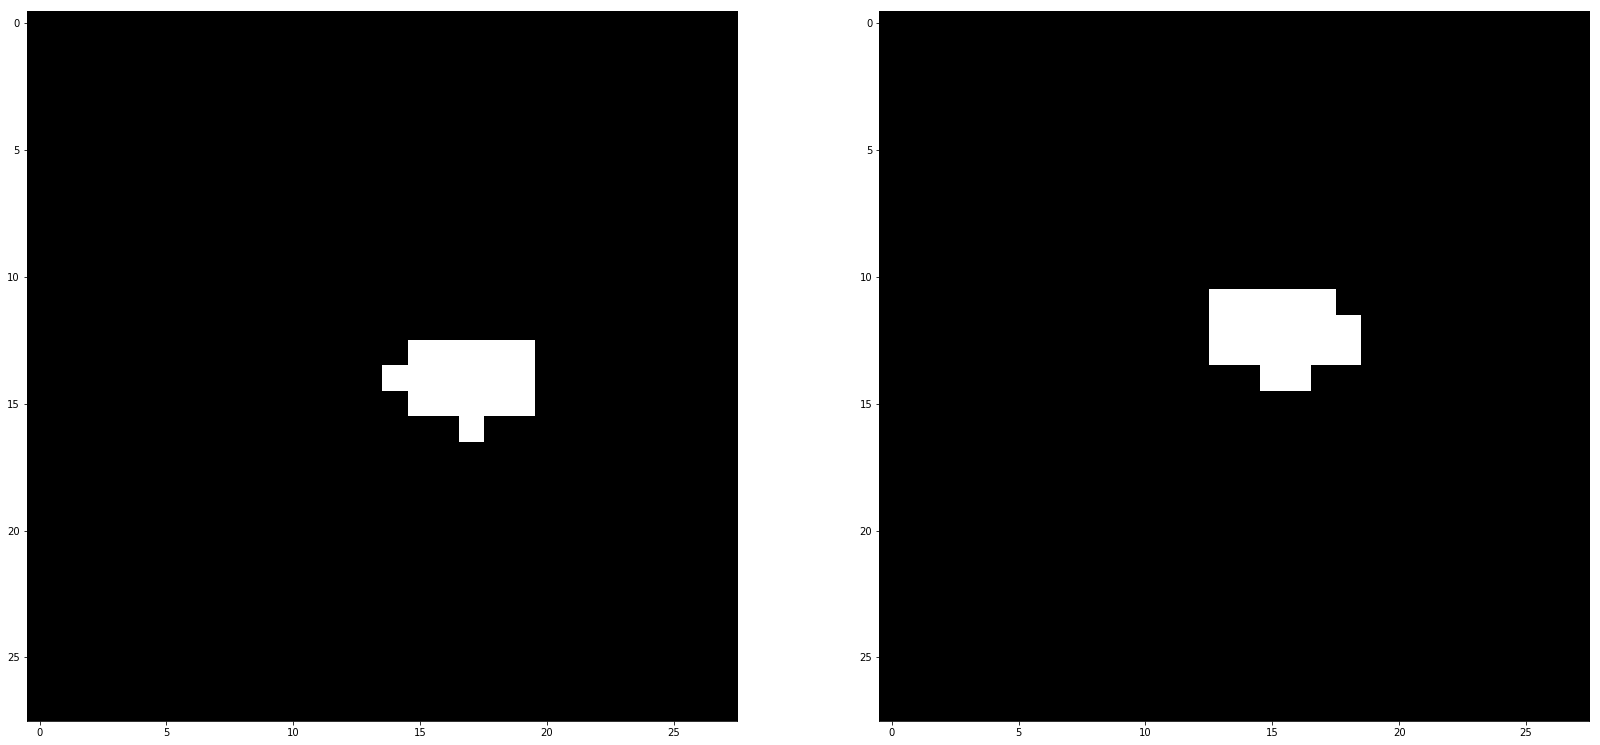

In [51]:
from DataFactory import generate
index = np.random.randint(vectors.shape[0])

image_sample = images[index].reshape(-1,4,14,14,1)
prediction = model.predict(image_sample)
prediction = prediction.reshape(prediction.shape[1])
prediction_image = np.zeros((28,28))
for i in range(0, len(prediction), 4):
    prediction_image += generate(np.round(prediction[i]), np.round(prediction[i+1]), prediction[i+2]/10, prediction[i+3]/10)
print(prediction)
print(vectors[index])

# prediction_image[prediction_image > 0] = 1
# prediction_image[prediction_image <= 0] = 0

image_sample = image_sample.reshape(4, 14, 14)
full = np.zeros((28,28))
full[0:14, 0:14] += image_sample[0]
full[0:14, 14:28] += image_sample[1]
full[14:28, 0:14] += image_sample[2]
full[14:28, 14:28] += image_sample[3]

fig=plt.figure(figsize=(28, 28))
fig.add_subplot(1, 2, 1)
plt.imshow(full, cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(prediction_image, cmap='gray')

plt.show()